<center>
    <h1>CS 6476: Computer Vision, Fall 2019</h1>
    <h1>PS3</h1>
    <h3>Instructor: Devi Parikh</h3>
    <h3>Due: Wednesday, October 8th, 11:59 pm</h3>
</center>

## Instructions

Implement all of the functions described in this notebook. Then, apply the functions to generate mosaics of the provided images and some of your own.

**When you are done save this notebook with the images and mosaics clearly visible.**

Submit the notebook and other deliverables on Gradescope in the `PS3 Code` assignment (see the checklist below).

# 1 Programming: Image Mosaics [100 points]

In this exercise, you will implement an image stitcher that uses image warping and homographies to auto- matically create an image mosaic. We will focus on the case where we have two input images that should form the mosaic, where we warp one image into the plane of the second image and display the combined views. This problem will give some practice manipulating homogeneous coordinates, computing homography matrices, and performing image warps. For simplicity, we’ll specify corresponding pairs of points manually using mouse clicks. For extra credit, you can optionally implement an automated correspondence process with local feature matching.

**Python hints:**
1. Useful Modules: `numpy`, `scipy`, `imageio`, `matplotlib`
2. Useful Functions: `numpy.linalg.eig`, `numpy.linalg.inv`, `numpy.tile`, `numpy.meshgrid` 
3. There are some Python libraries that could do much of the work for this project. However, to get practice with how the algorithms work, we want you to write your own code.

### 1. Getting Correspondences

Implement the `pick_points` function in `pick-points.py` (included in the zip). The function should allow a user to manually identified corresponding points from two views. Hint: look up **matplotlib event handling** and the **matplotlib.widgets.Cursor** class.

The results will be sensitive to the accuracy of the corresponding points; when providing clicks, choose distinctive points in the image that appear in both views.

To use `pick-points.py` run:

```bash
# general usage:
python3 pick-points.py <path/to/image1.jpg> <path/to/image2.jpg>

# for example
python3 pick-points.py wdc1.jpg wdc2.jpg
```

The selected points will be saved to `<path/to/image1.npy>` and `<path/to/image2.npy>`.

*Include `pick-points.py` in your submission.*

## Imports

In [3]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
#############################################################################
# TODO: Add additional imports
#############################################################################
from scipy.interpolate import griddata
# np.set_printoptions(suppress=False)
# large_width = 400
# np.set_printoptions(linewidth=large_width)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 2. Computing the Homography Parameters [20 points]

Implement the `compute_homography(t1, t2)` function as described below.

Be sure to handle homogenous and non-homogenous coordinates correctly. Look at the notes on how to estimate a homography [here](https://gatech.box.com/shared/static/yl4t92swxn4ffa928cec4lfz22csk86t.pdf).

> Note: Your estimation procedure may perform better if image coordinates range from 0 to 2. Consider scaling your measurements to avoid numerical issues.

**Manually export your function into a file named `compute_homography.py`. Add (only) the required imports and submit this file.**

In [4]:
def compute_homography(t1, t2):
    """
    Computes the Homography matrix for corresponding image points t1 and t2

    The function should take a list of N ≥ 4 pairs of corresponding points 
    from the two views, where each point is specified with its 2d image 
    coordinates.

    Inputs:
    - t1: Nx2 matrix of image points from view 1
    - t2: Nx2 matrix of image points from view 2

    Returns a tuple of:
    - H: 3x3 Homography matrix
    """
    H = np.eye(3)
    #############################################################################
    # TODO: Compute the Homography matrix H for corresponding image points t1, t2
    #############################################################################
    N = t1.shape[0]
    P = t1
    Q = t2

    # Note vectors coming in as if they are transposed
    p = np.concatenate(( P, np.ones((N,1)) ), axis=1)
    q = np.concatenate(( Q, np.ones((N,1)) ), axis=1)

    L = np.zeros((2 * N, 9))

    L[::2, 0:3] = p 
    L[1::2, 3:6] = p

    L[:, 6:9] = -1 * np.tile(np.reshape(Q,(2 * N, 1)), (1,3))

    # Because im stupid and worrying about things just do element wise multiplication of the stacked vectors
    L[:, 6:9] = np.multiply(L[:, 6:9], np.repeat(p, 2, axis=0)) # going down rows to create 2 * N data

    values, vectors = np.linalg.eig(np.transpose(L).dot(L))
    
    h = vectors[:, np.argmin(values)]

    H = -1 * h.reshape((3,3))

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return H

# Verify that the homography matrix your function computed is correct by mapping the clicked image points from one view to the other, and displaying them on top of each respective image.

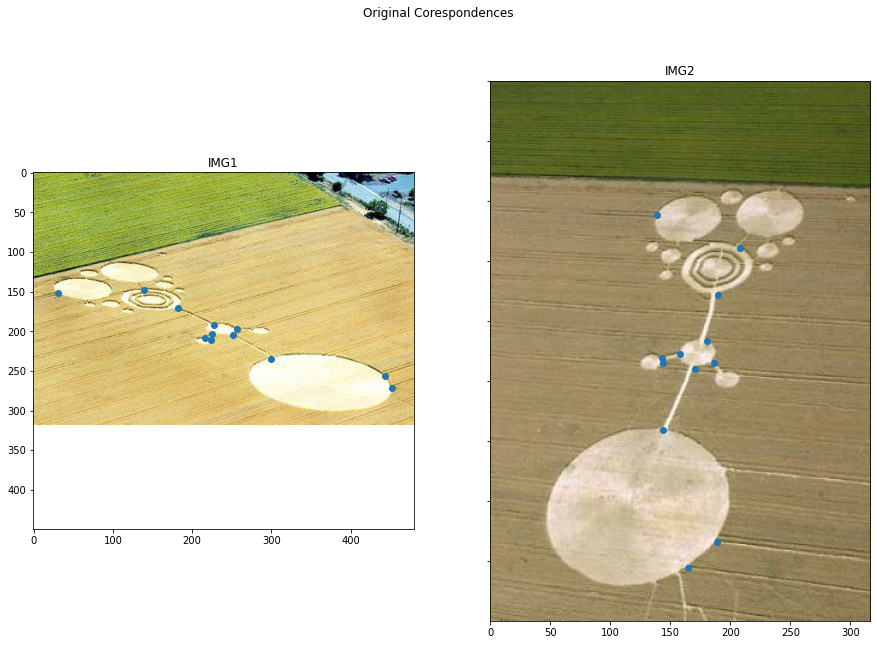

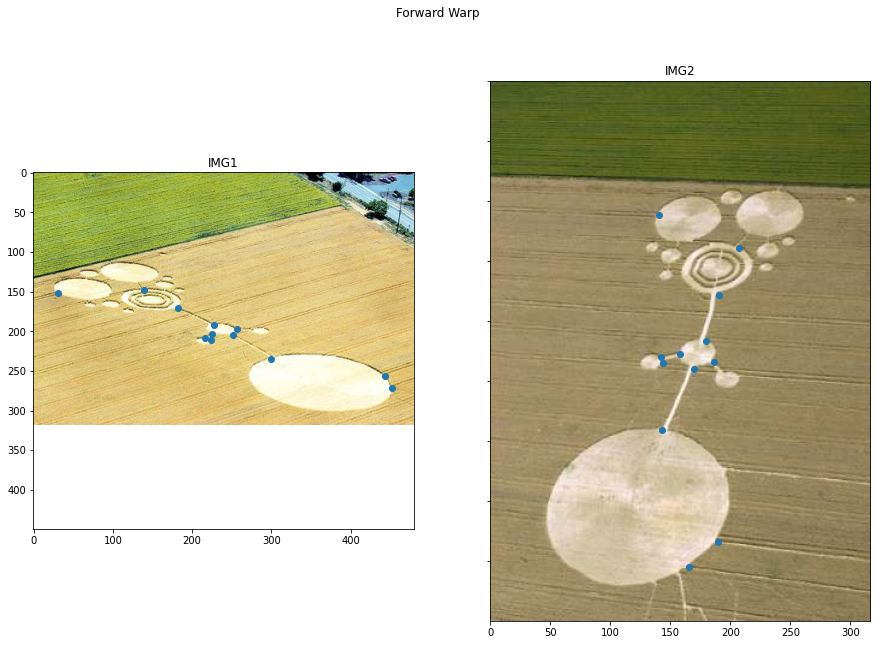

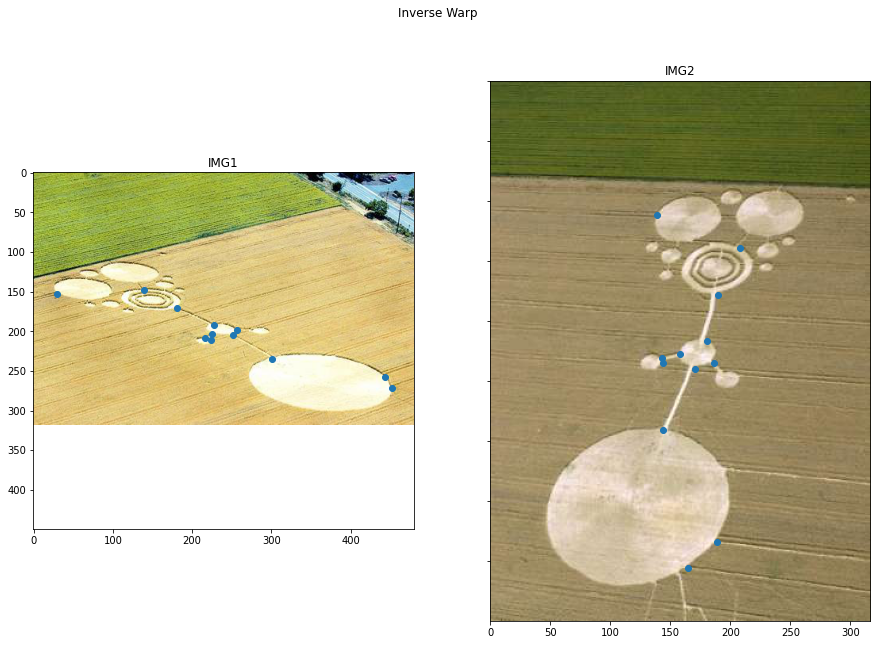

In [6]:
#############################################################################
# TODO: Verify Homography matrix
#############################################################################

img1 = np.asarray(imageio.imread("crop1.jpg"))
img2 = np.asarray(imageio.imread("crop2.jpg"))

t1 = np.load("cc1.npy")
t2 = np.load("cc2.npy")

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Original Corespondences', fontsize=12)
axes[0].imshow(img1)
axes[0].set_title("IMG1")
axes[0].scatter(t1[:,0], t1[:,1])

axes[1].imshow(img2)
axes[1].set_title("IMG2")
axes[1].scatter(t2[:,0], t2[:,1])

H = compute_homography(t1, t2)

#Forward Warp
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Forward Warp', fontsize=12)
axes[0].imshow(img1)
axes[0].set_title("IMG1")
axes[1].imshow(img2)
axes[1].set_title("IMG2")

p = np.concatenate(( t1, np.ones((t1.shape[0],1)) ), axis=1)
qprime = H.dot(p.transpose()) # 3x3 times 3xN which makes makes a 3xN result

axes[0].scatter(t1[:,0], t1[:,1])
axes[1].scatter(np.divide(qprime[0,:], (qprime[2,:])), np.divide(qprime[1,:], (qprime[2,:])))

#Inverse Warp
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Inverse Warp', fontsize=12)
axes[0].imshow(img1)
axes[0].set_title("IMG1")
axes[1].imshow(img2)
axes[1].set_title("IMG2")

Hinv = np.linalg.inv(H)

q = np.concatenate(( t2, np.ones((t2.shape[0],1)) ), axis=1)

pprime = Hinv.dot(q.transpose()) # 3x3 times 3xN which makes makes a 3xN result

axes[0].scatter(np.divide(pprime[0,:], (pprime[2,:])), np.divide(pprime[1,:], (pprime[2,:])))
axes[1].scatter(t2[:,0], t2[:,1])


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 3. Warping Between Image Planes [30 points]

Write a function `warp_image, merge_image = warp_image(input_image, ref_image, H)` which takes as input an image `input_image`, a reference image `ref_image`, and a 3x3 homography matrix `H`, and returns 2 images as outputs. The first output image, `warp_image`, should be the the input image `input_image` warped according to `H` to be in the frame of the reference image `ref_image`. The second output image, `merge_image`, should be a single mosaic image with a larger field of view containing both the input images. *Note: the output images will have a different shape than the input images.*

To avoid holes, use an *inverse warp*. Calculate the bounding box in the reference frame of the destination image by warping all of the points from the source image into the reference frame of the destination. Then, sample all of the points in that bounding box from the proper coordinates in the source image.

Once you have the input image warped into the reference image’s frame of reference, create a merged image showing the mosaic. Create a new image large enough to hold both the views; overlay one view onto the other, simply leaving it black wherever no data is available. Don’t worry about artifacts that result at the boundaries.

In [21]:
def warp_image(input_image, ref_image, H):
    """
    Warps and merges an input image onto the reference image. 

    Inputs:
    - input_image: input image
    - ref_image: reference image
    - H: 3x3 homography matrix

    Returns a tuple of:
    - warp_image: The input image warped according to H.
    - merge_image: A single mosaic image containing both of the input images.
    """

    warped_image, merge_image = None, None
    #############################################################################
    # TODO: Compute the Homography matrix H for corresponding image points t1, t2
    #############################################################################

    # Calculate bounding box image size
    print(type(input_image))
    print(input_image.shape)
    xcoords, ycoords = np.meshgrid(np.arange(input_image.shape[1]), np.arange(input_image.shape[0]), indexing='xy')
    input_coordinate_grid = np.array([np.ravel(xcoords), np.ravel(ycoords), np.ravel(np.ones(xcoords.shape))])
    print(xcoords.shape)
    print("input grid")
    print(input_coordinate_grid)
    print(input_coordinate_grid.shape)

    forward_grid = H.dot(input_coordinate_grid) # Transform
    forward_grid = np.divide(forward_grid[0:2,:], forward_grid[2,:]) # convert back from homogenous

   

    x_min = np.min(forward_grid[0,:])
    x_max = np.max(forward_grid[0,:])
    y_min = np.min(forward_grid[1,:])
    y_max = np.max(forward_grid[1,:])

    x_shift = int(np.abs(x_min))
    y_shift = int(np.abs(y_min))
    x_bound = int(np.ceil(x_max + np.abs(x_min))) # needs to be from zero so shift by x min
    y_bound = int(np.ceil(y_max + np.abs(y_min))) # needs to be from zero so shift by y min

    warped_image = np.zeros((y_bound, x_bound, 3)) # Everything has been right up till here

    # Reverse process to get sampling for warped image
    # Note since we use range this is shifted to start at zero
    xcoords, ycoords = np.meshgrid(np.arange(warped_image.shape[1]), np.arange(warped_image.shape[0]), indexing='xy') # create a y bound by x bound sized grid of coords
    target_coordinate_grid = np.array([np.ravel(xcoords), np.ravel(ycoords), np.ravel(np.ones(xcoords.shape))]) # flatten it for easier processing

    target_coordinate_grid[0, :] = target_coordinate_grid[0, :] - x_shift # Shift back by xmin
    target_coordinate_grid[1, :] = target_coordinate_grid[1, :] - y_shift # Shift back by ymin

    Hinv = np.linalg.inv(H)
    print(target_coordinate_grid)
    inverse_grid = Hinv.dot(target_coordinate_grid) # Transform
    inverse_grid = np.divide(inverse_grid[0:2,:], inverse_grid[2,:]) # convert back from homogenous

    # NOTE at this point inverse grid is 2 x pixel count

    sample_coords = inverse_grid.transpose() # make N by 2 for Interpolation

    xcoords, ycoords = np.meshgrid(np.arange(input_image.shape[1]), np.arange(input_image.shape[0]), indexing='xy') # create a y bound by x bound sized grid of coords
    input_coords = np.array([np.ravel(xcoords), np.ravel(ycoords)]).transpose()

    red_output = griddata(points = input_coords, values = np.ravel(input_image[:,:,0]), xi = sample_coords, method = 'linear', fill_value=0)
    warped_image[:, :, 0] = np.reshape(red_output, (warped_image.shape[0], warped_image.shape[1]))

    green_output = griddata(points = input_coords, values = np.ravel(input_image[:,:,1]), xi = sample_coords, method = 'linear', fill_value=0)
    warped_image[:, :, 1] = np.reshape(green_output, (warped_image.shape[0], warped_image.shape[1]))

    blue_output = griddata(points = input_coords, values = np.ravel(input_image[:,:,2]), xi = sample_coords, method = 'linear', fill_value=0)
    warped_image[:, :, 2] = np.reshape(blue_output, (warped_image.shape[0], warped_image.shape[1]))

    warped_image = warped_image.astype(np.uint8)

    # Create Merged Image
    merge_image = np.zeros((max(warped_image.shape[0], ref_image.shape[0]), max(warped_image.shape[1], ref_image.shape[1]), 3))
    
    if (warped_image.shape[0] < ref_image.shape[0]) or (warped_image.shape[1] < ref_image.shape[1]):
      print("larger ref")
      # Trim warped image
      # apparently this only needs to be done when the warped image needs to be shifted which I guess makes sense because if the warp doesnt need to be shifted the whole point is its been calculated in terms of the reference image
      valid_points = np.argwhere(warped_image)
      top_left = valid_points.min(axis=0)
      bottom_right = valid_points.max(axis=0)
      warped_image = warped_image[top_left[0]:bottom_right[0] + 1, top_left[1]:bottom_right[1] + 1]

      merge_image[ 0:ref_image.shape[0], 0:ref_image.shape[1] ] = ref_image # Copy ref image over entire region
      ref_image_cut = ref_image[ y_shift:warped_image.shape[0] + y_shift, x_shift:warped_image.shape[1] + x_shift ] # subsection of the reference image where the trimmed warped image is about to be overlaid
      warped_alphaed = np.where(warped_image > 0.0, warped_image, ref_image_cut)
      merge_image[ y_shift:warped_image.shape[0] + y_shift, x_shift:warped_image.shape[1] + x_shift ] = warped_alphaed # Shift the warped_image into the right location
    else:
      print("smaller ref")
      merge_image[ 0:warped_image.shape[0], 0:warped_image.shape[1] ] = warped_image  # Copy warped image over entire region
      merge_image[ y_shift:ref_image.shape[0] + y_shift, x_shift:ref_image.shape[1] + x_shift ] = ref_image # Shift the reference image into the right location

    # 2nd round of trimming to make merged look nice
    valid_points = np.argwhere(merge_image)
    top_left = valid_points.min(axis=0)
    bottom_right = valid_points.max(axis=0)
    merge_image = merge_image[top_left[0]:bottom_right[0] + 1, top_left[1]:bottom_right[1] + 1]

    warped_image = warped_image.astype(np.uint8)
    merge_image = merge_image.astype(np.uint8)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return warped_image, merge_image

### 4. Apply System to Provided Images [15 points]

### 4a. Apply System to crop1.jpg and crop2.jpg

Apply your system to `crop1.jpg` and `crop2.jpg` using the corresponding points `cc1.npy` and `cc2.npy`. The images and points are included in the zip file.

*Display the warped and mosaic images in this notebook. Make sure both images are visible when you save (and submit) the notebook.*

<class 'numpy.ndarray'>
(319, 480, 3)
(319, 480)
input grid
[[  0.   1.   2. ... 477. 478. 479.]
 [  0.   0.   0. ... 318. 318. 318.]
 [  1.   1.   1. ...   1.   1.   1.]]
(3, 153120)
[[-123. -122. -121. ...  819.  820.  821.]
 [ -55.  -55.  -55. ...  470.  470.  470.]
 [   1.    1.    1. ...    1.    1.    1.]]
smaller ref


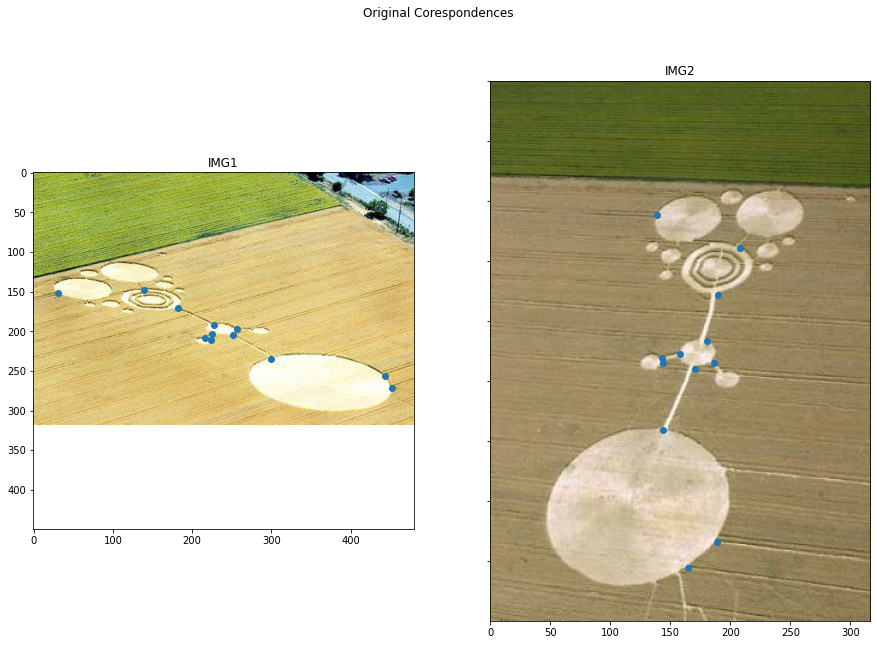

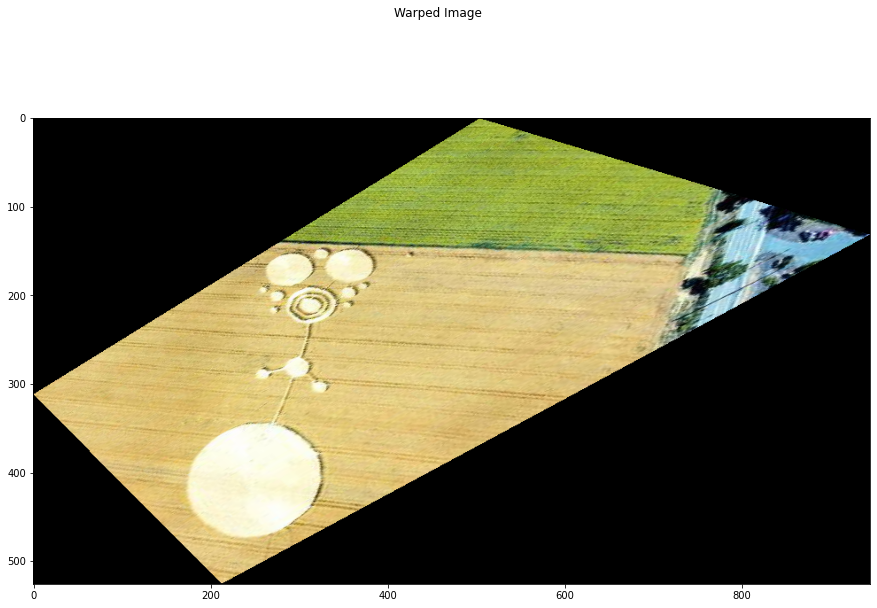

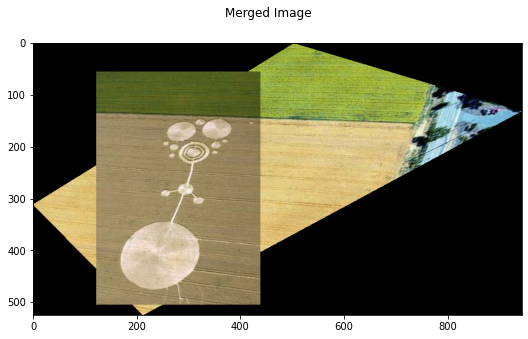

In [22]:
#############################################################################
# TODO: Apply system to Pair 1
#############################################################################

input_image = np.asarray(imageio.imread("crop1.jpg"))
ref_image = np.asarray(imageio.imread("crop2.jpg"))

t1 = np.load("cc1.npy")
t2 = np.load("cc2.npy")

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Original Corespondences', fontsize=12)
axes[0].imshow(input_image)
axes[0].set_title("IMG1")
axes[0].scatter(t1[:,0], t1[:,1])

axes[1].imshow(ref_image)
axes[1].set_title("IMG2")
axes[1].scatter(t2[:,0], t2[:,1])

H = compute_homography(t1, t2)
# H = compute_homography(t2, t1)

#Inverse Warp
warped_image, merge_image = warp_image(input_image, ref_image , H)
# warped_image, merge_image = warp_image(ref_image, input_image , H)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Warped Image', fontsize=12)
plt.imshow(warped_image)

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Merged Image', fontsize=12)
plt.imshow(merge_image)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 4b. Apply System to wdc1.jpg and wdc2.jpg

Apply your system to `wdc1.jpg` and `wdc2.jpg` using an appropriate choice of (manually selected) corresonding points. Only the images are included in the zip file.

*Display the warped and mosaic images in this notebook. Make sure both images are visible when you save (and submit) the notebook.*

smaller ref


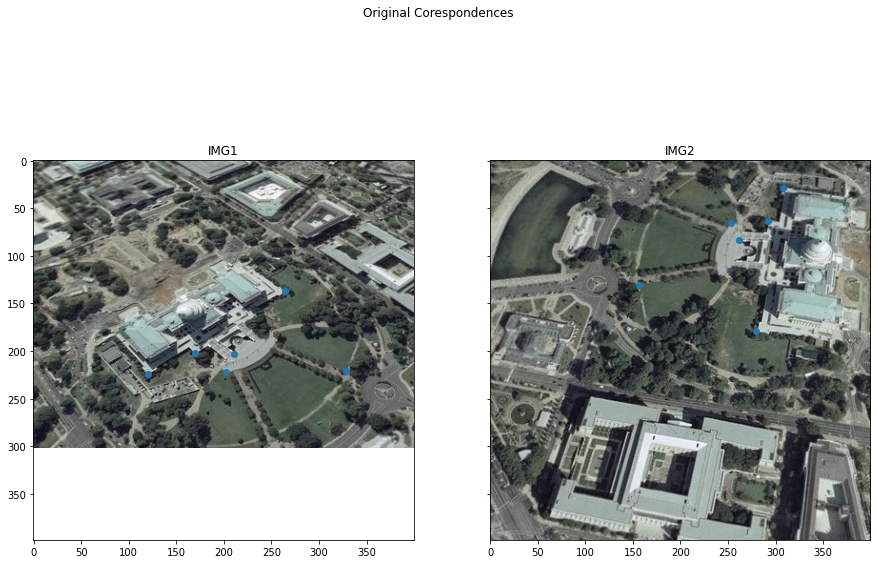

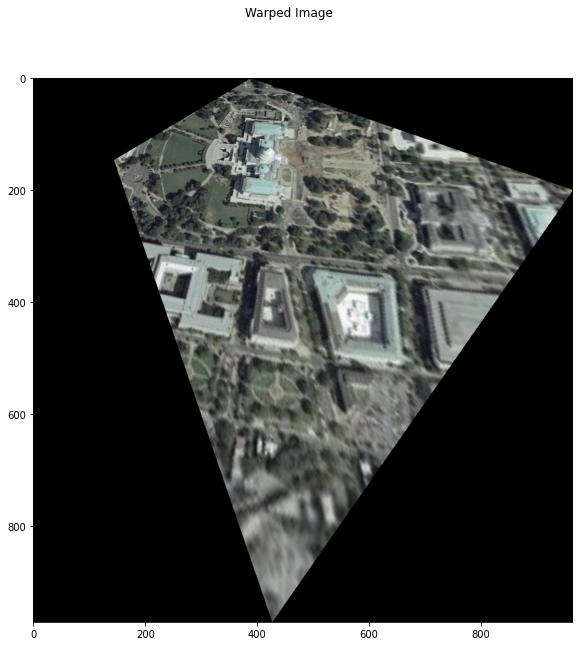

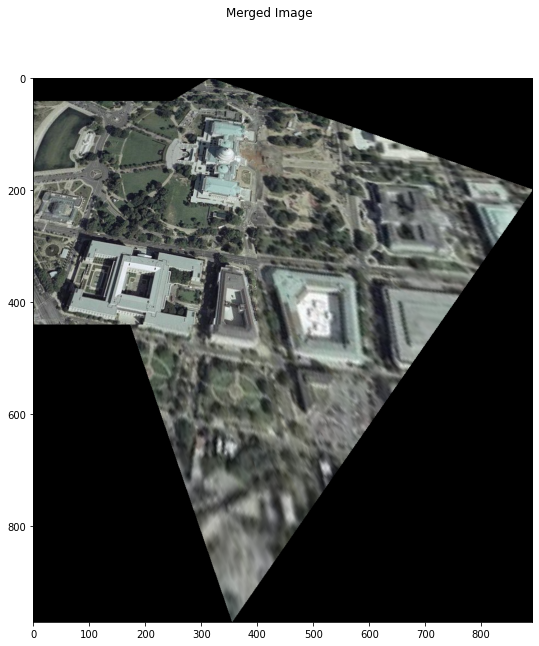

In [ ]:
#############################################################################
# TODO: Apply system to Pair 2
#############################################################################
input_image = np.asarray(imageio.imread("wdc1.jpg"))
ref_image = np.asarray(imageio.imread("wdc2.jpg"))

t1 = np.load("wdc1.npy")
t2 = np.load("wdc2.npy")

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Original Corespondences', fontsize=12)
axes[0].imshow(input_image)
axes[0].set_title("IMG1")
axes[0].scatter(t1[:,0], t1[:,1])

axes[1].imshow(ref_image)
axes[1].set_title("IMG2")
axes[1].scatter(t2[:,0], t2[:,1])

H = compute_homography(t1, t2)
# H = compute_homography(t2, t1)

#Inverse Warp
warped_image, merge_image = warp_image(input_image, ref_image , H)
# warped_image, merge_image = warp_image(ref_image, input_image , H)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Warped Image', fontsize=12)
plt.imshow(warped_image)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Merged Image', fontsize=12)
plt.imshow(merge_image)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 5. Custom Mosaic [20 points]
Show one additional example of a mosaic you create using images that you have taken. You might make a mosaic from two or more images of a broad scene that requires a wide angle view to see well. Or, make a mosaic using two images from the same room where the same person appears in both.

*Display the original images and the mosaic in this notebook. Make sure all of the images are visible when you save (and submit) the notebook.*

smaller ref


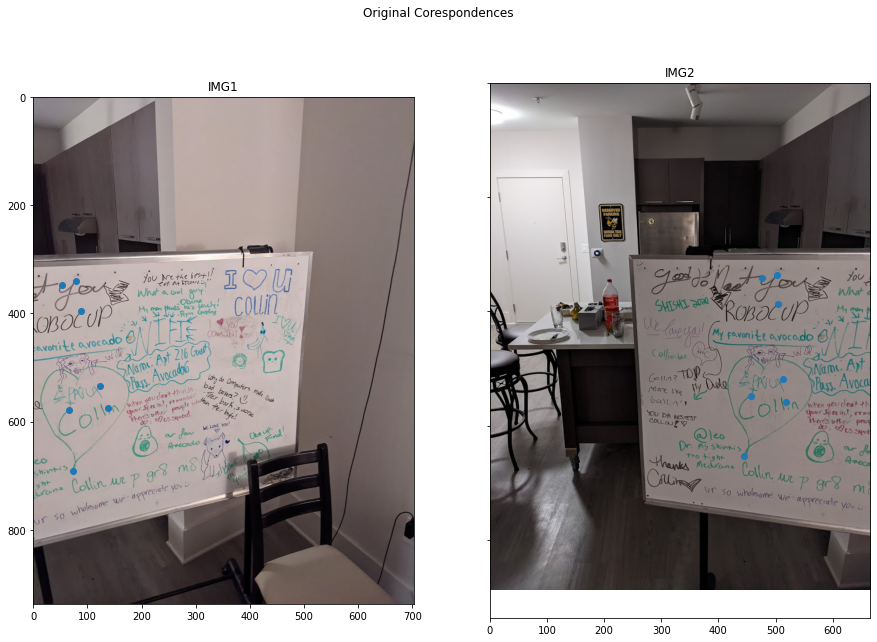

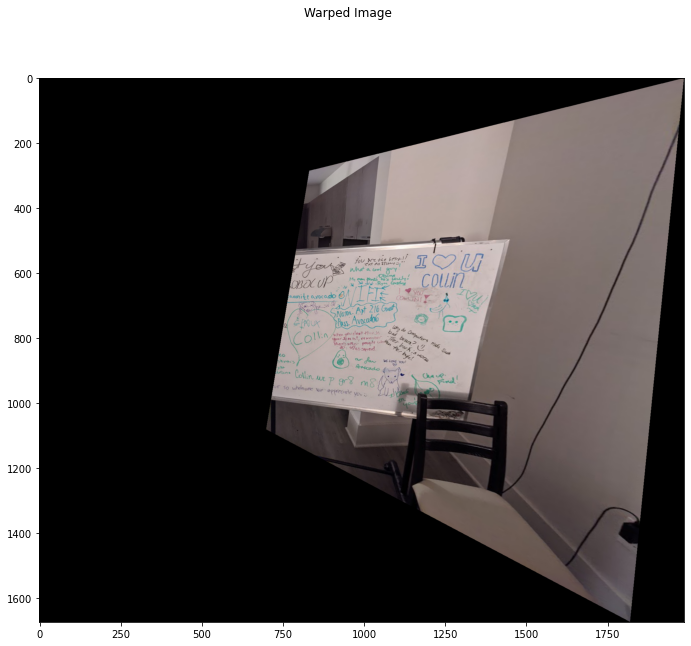

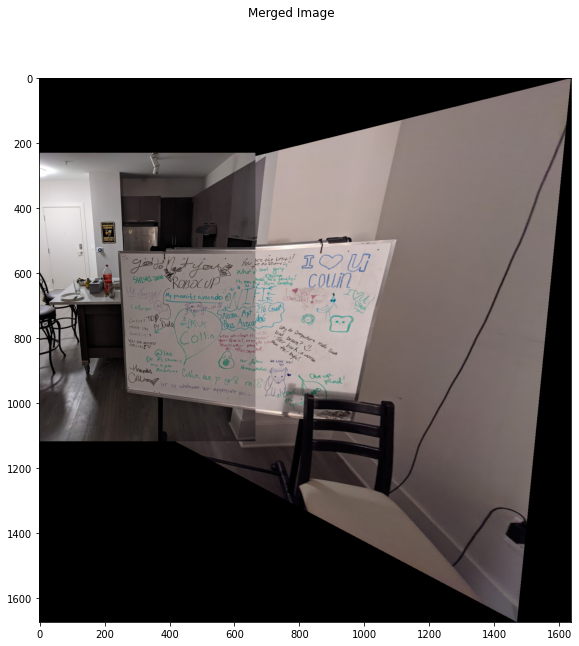

In [ ]:
#############################################################################
# TODO: Apply system to create a custom mosaic
#############################################################################

input_image = np.asarray(imageio.imread("board1.jpg"))
ref_image = np.asarray(imageio.imread("board2.jpg"))

t1 = np.load("board1.npy")
t2 = np.load("board2.npy")

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Original Corespondences', fontsize=12)
axes[0].imshow(input_image)
axes[0].set_title("IMG1")
axes[0].scatter(t1[:,0], t1[:,1])

axes[1].imshow(ref_image)
axes[1].set_title("IMG2")
axes[1].scatter(t2[:,0], t2[:,1])

H = compute_homography(t1, t2)
# H = compute_homography(t2, t1)

#Inverse Warp
warped_image, merge_image = warp_image(input_image, ref_image , H)
# warped_image, merge_image = warp_image(ref_image, input_image , H)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Warped Image', fontsize=12)
plt.imshow(warped_image)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Merged Image', fontsize=12)
plt.imshow(merge_image)


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

### 6. Custom Warp [15 points]

Warp one image into a frame region in the second image. To do this, let the points from the one view be the corners of the image you want to insert in the frame, and let the corresponding points in the second view be the clicked points of the frame (rectangle) into which the first image should be warped. Use this idea to replace one surface in an image with an image of something else. For example – overwrite a billboard with a picture of your dog, or project a drawing from one image onto the street in another image, or replace a portrait on the wall with someone else’s face, or paste a Powerpoint slide onto a movie screen, etc.

*Display the original images and the mosaic in this notebook. Make sure all of the images are visible when you save (and submit) the notebook.*

H is: 
[[ 3.83462463e-03  1.06262473e-03  5.58466124e-01]
 [-7.70546865e-04  2.73308084e-03  8.29502941e-01]
 [ 6.34011131e-07 -8.20710008e-07  4.06959925e-03]]
x_shift 137
y_shift 140
larger ref


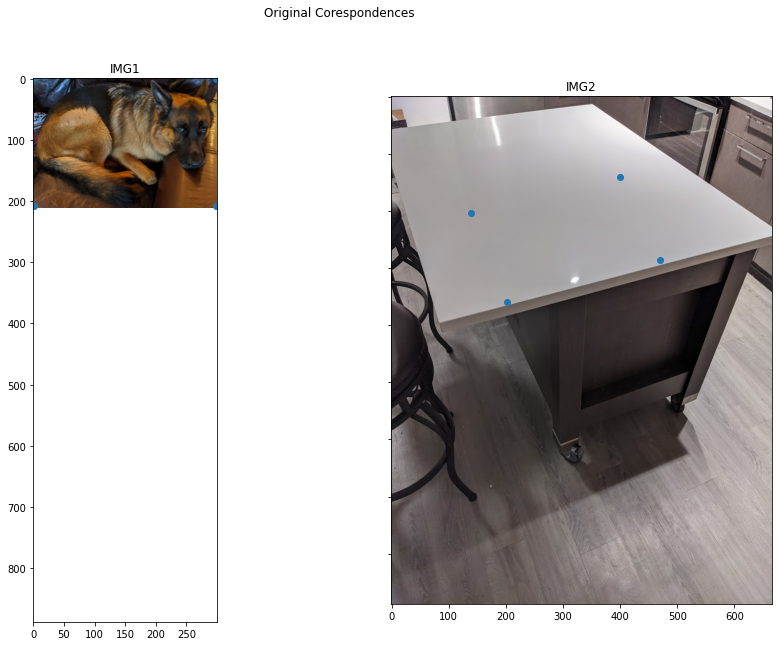

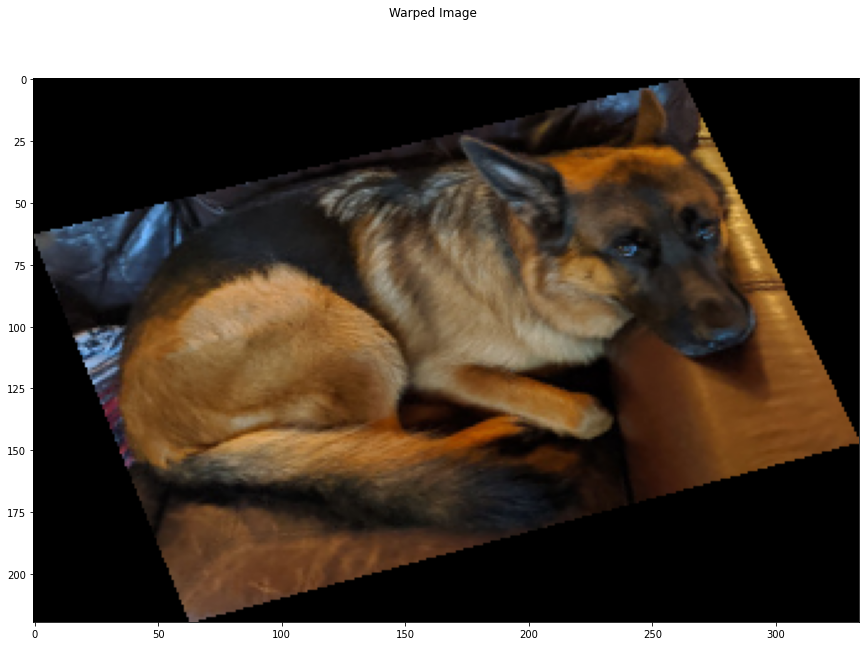

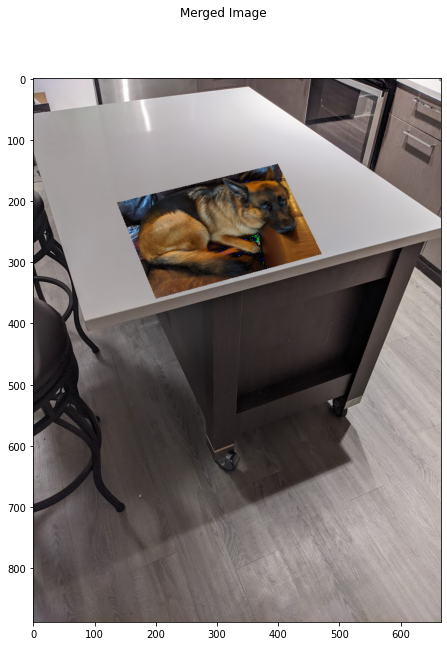

In [ ]:
#############################################################################
# TODO: Apply system to create a custom warp
#############################################################################

input_image = np.asarray(imageio.imread("doggo.jpg"))
ref_image = np.asarray(imageio.imread("counter.jpg"))

t1 = np.load("doggo.npy")
t2 = np.load("counter.npy")

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
fig.suptitle('Original Corespondences', fontsize=12)
axes[0].imshow(input_image)
axes[0].set_title("IMG1")
axes[0].scatter(t1[:,0], t1[:,1])

axes[1].imshow(ref_image)
axes[1].set_title("IMG2")
axes[1].scatter(t2[:,0], t2[:,1])

H = compute_homography(t1, t2)
# H = compute_homography(t2, t1)

#Inverse Warp
warped_image, merge_image = warp_image(input_image, ref_image , H)
# warped_image, merge_image = warp_image(ref_image, input_image , H)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Warped Image', fontsize=12)
plt.imshow(warped_image)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Merged Image', fontsize=12)
plt.imshow(merge_image)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# 2 [OPTIONAL] Extra Credit [up to 10 points each, max 30 points]

Add as any more cells as needed to implement the following. Please include all implementation and results in the final submission to be considered for extra credit. 

### 1. Automatic Interest Point Detection + Local Feature Matching

Replace the manual correspondence stage with automatic interest point detection and local feature matching. Check out available code here to compute the local interest points and features:

[http://www.vlfeat.org/overview/sift.html](http://www.vlfeat.org/overview/sift.html)

[http://www.robots.ox.ac.uk/~vgg/research/affine/detectors.html](http://www.robots.ox.ac.uk/~vgg/research/affine/detectors.html)

*Display the automatically detected and matched points in this notebook.*

### 2. RANSAC
Implement RANSAC for robustly estimating the homography matrix from noisy correspondences. Show with an example where it successfully gives good results even when there are outlier (bad) corre- spondences given as input. Compare the robust output to the original (non-RANSAC) implementation where all correspondences are used.

*Display the original images and results in this notebook. Make sure all of the images are visibel when you save (and submit) the notebook.*

### 3. Rectification 

Rectify an image with some known planar surface (say, a square floor tile, or the rectangular face of a building facade) and show the virtual fronto-parallel view. In this case there is only one input image. To solve for H, you define the correspondences by clicking on the four corners of the planar surface in the input image, and then associating them with hand-specified coordinates for the output image. For example, a square tile’s corners from the non-frontal view could get mapped to [0 0; 0 N; N 0; N N] in the output.

*Display the original and rectified images in this notebook. Make sure both images are visible when you save (and submit) the notebook.*

### 4. Short Video
Make a short video in the style of the [HP commercial](https://www.youtube.com/watch?v=2RPl5vPEoQk)’s video which you saw in class. Building on #3 above, let the frame in the output video move to different positions over time, and warp the framed image into the correct position for every video frame in the sequence.

*Name the video `ps3-extra-credit.mp4` and submit it.*

# 3 Deliverable Checklist

- [ ] `ps3.ipynb`
- [ ] `compute_homography.py`
- [ ] `pick-points.py`
- [ ] [extra credit] `ps3-extra-credit.mp4`

Im so sick of this class. I wasted so many hours on this assignment and just the lack of a tester or any support is just constantly aggrivating. Im so done with this stupid class. Im sorry.